In [17]:
import torch 
import matplotlib.pyplot as plt

from torch.distributions import Normal, MixtureSameFamily, Categorical, Independent
import torch

from rbibm.tasks.cde import MixtureDist
from rbi.models import NeuralSplineFlow, MixtureDiagGaussianModel, SplineAutoregressiveModel
from rbi.defenses import FIMTraceRegularizer, FIMLargestEigenvalueRegularizer
from rbi.loss import NLLLoss

torch.manual_seed(0)

In [18]:
task = MixtureDist()
generator = task.get_generator()
train_loader, _, _ = task.get_train_test_val_dataset(1000, 10000, 0)

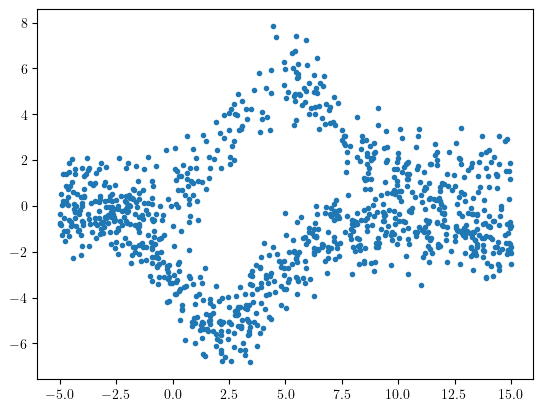

In [19]:
for X, y in train_loader:
    plt.scatter(X,y, marker=".", color="C0")

In [20]:
net = SplineAutoregressiveModel(1,1, bound=20, num_transforms=1, count_bins=20)
#net = NeuralSplineFlow(1,1, num_transforms=4, bins=20)
#'net = MixtureDiagGaussianModel(1,1, num_components=4)
loss_fn = NLLLoss(net)

c:\ProgramData\Miniconda3\lib\site-packages\pyro\nn\auto_reg_nn.py:179: UserWarning: ConditionalAutoRegressiveNN input_dim = 1. Consider using an affine transformation instead.
  warnings.warn(


In [21]:
optim = torch.optim.Adam(net.parameters())

for i in range(1000):
    for X,Y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X,Y)
        loss.backward()
        optim.step()

In [22]:
net2 = SplineAutoregressiveModel(1,1, bound=15, num_transforms=1, count_bins=20)
#net2 = NeuralSplineFlow(1,1, num_transforms=4, bins=20)
#net2 = MixtureDiagGaussianModel(1,1, num_components=4)
loss_fn = NLLLoss(net2)
defense = FIMTraceRegularizer(net2, loss_fn, beta=0.2, algorithm="ema", ema_decay=0.9)
# defense = GaussianNoiseTransformRegularizer(net2, loss_fn, 0.5, mc_samples=20)
defense.activate()

In [23]:
optim = torch.optim.Adam(net2.parameters(), lr=1e-3)

for i in range(1000):
    for X,Y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X,Y)
        loss.backward()
        optim.step()

In [24]:
from rbibm.plots.styles import use_style

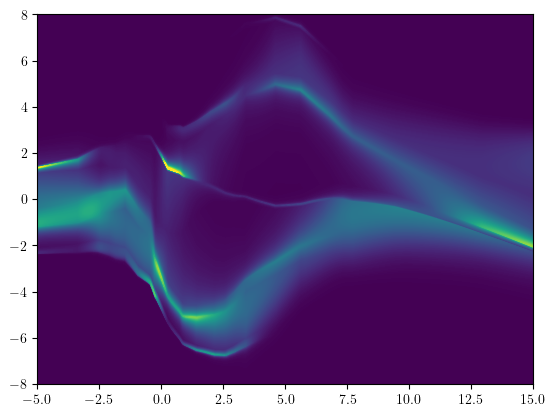

In [25]:
x = torch.linspace(-5,15,1000)
y = torch.linspace(-8,8,1000)

xx,yy = torch.meshgrid(x,y)
pos = torch.hstack([xx.reshape(-1,1), yy.reshape(-1,1)])

Z= net(pos[:,0].unsqueeze(-1)).log_prob(pos[:,1].unsqueeze(-1)).detach().exp()
plt.contourf(xx,yy, Z.reshape(xx.shape), cmap="viridis", levels=500, vmax=0.8)

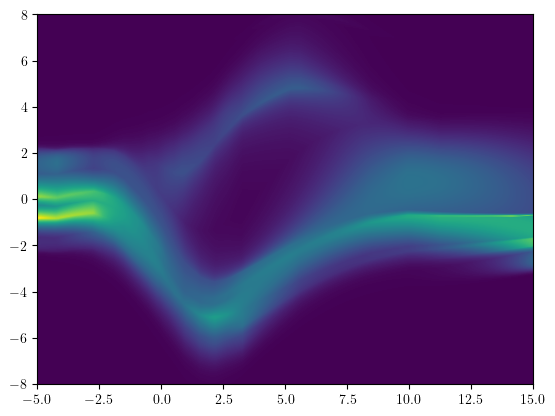

In [26]:
x = torch.linspace(-5,15,1000)
y = torch.linspace(-8,8,1000)

xx,yy = torch.meshgrid(x,y)
pos = torch.hstack([xx.reshape(-1,1), yy.reshape(-1,1)])

Z1= net2(pos[:,0].unsqueeze(-1)).log_prob(pos[:,1].unsqueeze(-1)).detach().exp()
plt.contourf(xx,yy, Z1.reshape(xx.shape), cmap="viridis", levels=500)

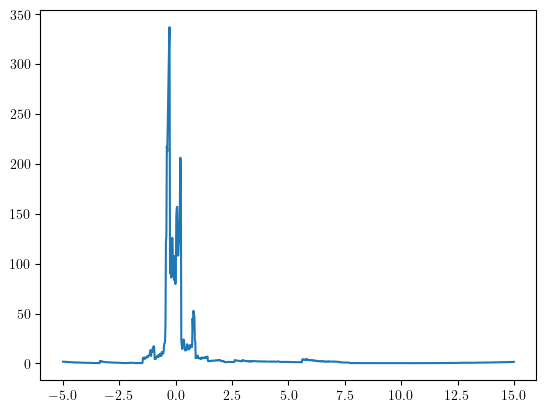

In [27]:
from rbi.utils.fisher_info import monte_carlo_fisher

F_x1 = torch.vstack([monte_carlo_fisher(net,x[i*100:(i+1)*100].reshape(-1,1), mc_samples=5000, create_graph=False) for i in range(10)])
plt.plot(x, F_x1.squeeze())

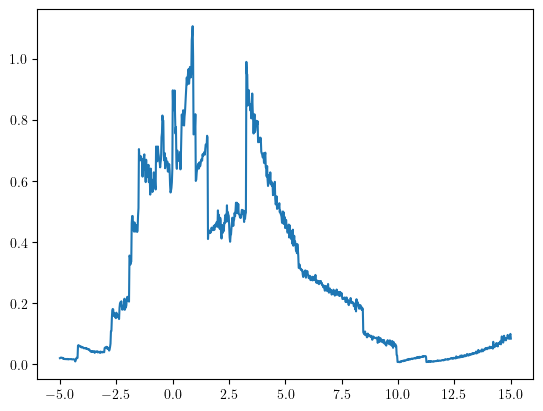

In [28]:
from rbi.utils.fisher_info import monte_carlo_fisher

F_x2 = torch.vstack([monte_carlo_fisher(net2,x[i*100:(i+1)*100].reshape(-1,1), mc_samples=5000, create_graph=False) for i in range(10)])
plt.plot(x, F_x2.squeeze())

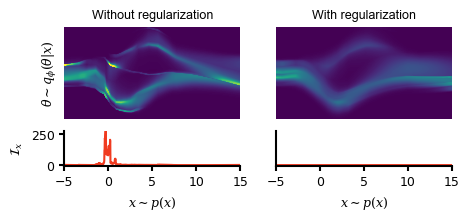

In [30]:
plt.rcParams['text.usetex'] = True
with use_style("pyloric"):
    fig, axes = plt.subplots(2, 2,figsize=(5,1.8), gridspec_kw={"height_ratios": [0.8, 0.3]})


    axes[0,1].set_xlim(-5,15)
    axes[0,1].set_ylim(-8, 8)
    axes[0,0].set_xlim(-5,15)
    axes[0,0].set_ylim(-8, 8)

    
    axes[0,0].set_title("Without regularization",font="Arial")
    cs = axes[0,0].contourf(xx,yy, Z.reshape(xx.shape), cmap="viridis", levels=500, vmax=0.8)
    for c in cs.collections:
        c.set_rasterized(True)
    axes[0,1].set_title("With regularization",font="Arial")
    cs = axes[0,1].contourf(xx,yy, Z1.reshape(xx.shape), cmap="viridis", levels=500, vmax=0.8)
    for c in cs.collections:
        c.set_rasterized(True)
    axes[0,0].set_xticks([])
    axes[0,1].set_xticks([])
    axes[0,1].set_yticks([])
    axes[0,0].set_ylabel("$\\theta \sim q_\\phi(\\theta|x)$", font="Arial")

    for tick in axes[0,0].yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)

    for tick in axes[0,0].yaxis.get_minor_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)

    axes[1,0].plot(x, F_x1.squeeze(), color="#f03b20", )
    axes[1,1].plot(x, F_x2.squeeze(), color="#f03b20",)
    axes[1,0].set_xlim(-5,15)
    axes[1,0].set_ylim(-5,275)
    axes[0,0].set_yticks([])
    axes[0,0].spines[['left', 'bottom']].set_visible(False)
    axes[0,1].spines[['left', 'bottom']].set_visible(False)
    #axes[1,0].set_yticks([0,25])
    axes[1,1].set_xlim(-5,15)
    axes[1,1].set_ylim(-5,275)
    axes[1, 0].set_ylabel("$\\mathcal{I}_x$", font="Arial")
    axes[1,1].set_yticks([])
    axes[1, 1].set_xlabel("$x \\sim p(x)$",font="Arial")
    axes[1, 0].set_xlabel("$x \\sim p(x)$",font="Arial")
    #fig.tight_layout()
    fig.savefig("fig1b.svg", transparent=True, bbox_inches="tight")
fig.savefig("fig1b_nonedit.svg", transparent=True, bbox_inches="tight")
